In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [14]:
Latest_date = session.query(func.max(Measurement.date)).all()
End_Date = Latest_date[0][0]
print(End_Date)

2017-08-23


In [15]:
#Step 2: Calculate the date 1 year ago from the last data point in the database
Struct = dt.date.today()
End_Date_dateformat = Struct.replace(year=int(End_Date[:4]),month=int(End_Date[5:7]),day=int(End_Date[8:]))
Last_date_year = End_Date_dateformat - dt.timedelta(days=365)    
Start_Date = Last_date_year.strftime("%Y-%m-%d")
print(Start_Date)

2016-08-23


In [16]:
print(f"Date range is starting from {Start_Date} and ending at {End_Date}")

Date range is starting from 2016-08-23 and ending at 2017-08-23


In [17]:
#Step 3: Perform a query to retrieve the data and precipitation scores
PRCP_data = session.query(Measurement.date,Measurement.prcp)\
                          .filter(Measurement.date <= End_Date)\
                          .filter(Measurement.date >= Start_Date)\
                          .order_by(Measurement.date.desc()).all()
# for data in PRCP_data: 
#     print(data)

In [18]:
#Step 4: Save the query results as a Pandas DataFrame and set the index to the date column and Sort the dataframe by date
PRCP_data_DF = pd.DataFrame(PRCP_data).rename(columns={"date":"Date","prcp":"Precipitation Score"})
PRCP_data_DF.set_index("Date",inplace=True)
PRCP_data_DF.head()

,Precipitation Score
Date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


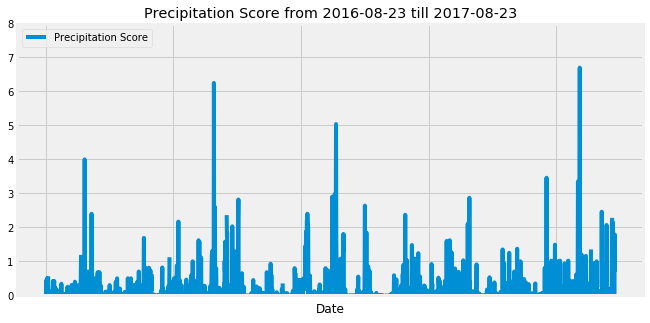

In [19]:
#Step 5: Use Pandas Plotting with Matplotlib to plot the data
PRCP_data_DF.plot(figsize=(10,5),ylim=(0,8),title=f'Precipitation Score from {Start_Date} till {End_Date}',\
                  label="Precipitation",rot=45)
plt.legend(loc="upper left")
plt.savefig("Images/1_Precipitation_Analysis.jpg")
plt.show()

![precipitation](Images/precipitation.png)

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
PRCP_data_DF.describe()

,Precipitation Score
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [21]:
# Design a query to show how many stations are available in this dataset?
Total_stations = session.query(Station).count()
print('Total number of stations is: {}'.format(Total_stations))

Total number of stations is: 9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Total_stations_reports = session.query(Measurement.station,func.count(Measurement.station))\
                                     .group_by(Measurement.station)\
                                     .order_by(func.count(Measurement.station).desc()).all()
Total_stations_reports

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
Station_Highest_Obs = session.query(Measurement.station,func.count(Measurement.station))\
                      .group_by(Measurement.station)\
                      .order_by(func.count(Measurement.station).desc()).first()
#print("\n**Using session.query and concatenating strings for printing**")
#Station_Highest_Obs  
print("The station with the highest number of observation is "+str(Station_Highest_Obs[0])+" with " +\
      str(Station_Highest_Obs[1]) + " number of observations.")

The station with the highest number of observation is USC00519281 with 2772 number of observations.


In [24]:
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
                  .filter(Measurement.station == Station_Highest_Obs[0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Results = session.query(Measurement.date,Measurement.station,Measurement.tobs)\
             .filter(Measurement.date >= Start_Date).filter(Measurement.date<=End_Date)\
             .filter(Measurement.station == Station_Highest_Obs[0]).order_by(Measurement.date.desc()).all()

In [26]:
Last12_tobs_DF = pd.DataFrame(Results,columns=["Date","Station ID","Temperature_Recorded"])
Last12_tobs_DF.head()

,Date,Station ID,Temperature_Recorded
0,2017-08-18,USC00519281,79.0
1,2017-08-17,USC00519281,76.0
2,2017-08-16,USC00519281,76.0
3,2017-08-15,USC00519281,77.0
4,2017-08-14,USC00519281,77.0


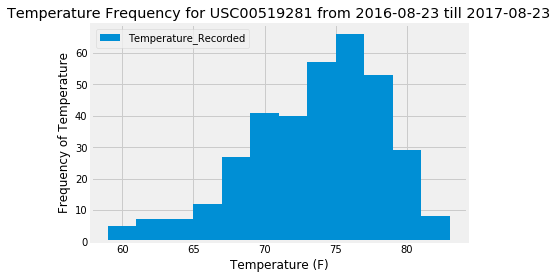

In [27]:
Last12_tobs_DF.plot.hist(by="Temperature_Recorded",bins=12,label="tobs",title=f'Temperature Frequency for {Station_Highest_Obs[0]} from {Start_Date} till {End_Date}')
plt.ylim=(0,80)
plt.ylabel("Frequency of Temperature")
plt.xlabel("Temperature (F)")
plt.legend=()
plt.savefig("Images/2_Temperature_Analysis.jpg")
plt.show()

![precipitation](Images/station-histogram.png)

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
Trip_start_date = input("Enter the trip start date in 'YYYY-MM-DD' format: ") # like 2018-02-03
Trip_end_date = input("Enter the trip end date in 'YYYY-MM-DD' format: ") #like 2018-05-03

In [ ]:
# Calculate the previous year's dates based on the input dates
Struct = dt.date.today()
Trip_start_date_dateformat = Struct.replace(year=int(Trip_start_date[:4]),month=int(Trip_start_date[5:7]),day=int(Trip_start_date[8:]))
Previous_Trip_start_date = Trip_start_date_dateformat - dt.timedelta(days=365)
Previous_Trip_start_date = Previous_Trip_start_date.strftime("%Y-%m-%d")
Previous_Trip_start_date
Trip_end_date_dateformat = Struct.replace(year=int(Trip_end_date[:4]),month=int(Trip_end_date[5:7]),day=int(Trip_end_date[8:]))
Previous_Trip_end_date = Trip_end_date_dateformat - dt.timedelta(days=365)
Previous_Trip_end_date = Previous_Trip_end_date.strftime("%Y-%m-%d")
Previous_Trip_end_date

In [ ]:
Result = calc_temps(Previous_Trip_start_date, Previous_Trip_end_date)
print(Result)

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = Result[0][0]
tavg = Result[0][1]
tmax = Result[0][2]
y_err = tmax-tmin

plt.figure(figsize=(2,10))
plt.bar(0,tavg,yerr=y_err,align="center",width=1,color="orange",alpha=0.5)
plt.ylim=(0,120)
plt.ylabel("Temperature(F)")
plt.title("Trip Avg Temperature")
plt.savefig("Images/3_Trip_Avg_Temp_Analysis.jpg")
plt.show()

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
Results = session.query(Measurement.station, func.sum(Measurement.prcp))\
                       .filter(Measurement.date>=Previous_Trip_start_date).filter(Measurement.date<=Previous_Trip_end_date)\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()  
print("Station Id\tTotal Rainfall")
for each in Results: print(each[0],"\t",each[1])

In [ ]:
sel = [Measurement.station,Station.name,func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation]
Results = session.query(*sel).filter(Measurement.station==Station.station)\
                       .filter(Measurement.date>=Previous_Trip_start_date).filter(Measurement.date<=Previous_Trip_end_date)\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

# print("Station\t\tStation_Name\t\tRainfall\tLatitude\tLongitude\tTemperature")
# for result in Results: print(result[0],"\t",result[1],"\t",result[2],"\t\t",result[3],"\t",result[4],"\t",result[5])

for result in Results: print(result)